<a href="https://colab.research.google.com/github/Calaria/pytorch_models/blob/main/custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
torch.__version__

'2.2.1+cu121'

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Get data

In [ ]:
import requests
import zipfile
from pathlib import Path

#set path
data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one ...")
  image_path.mkdir(parents=True, exist_ok= True)

  #Download
  with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating one ...
Unzipping pizza, steak, sushi data...


In [ ]:
# inspect the directory

import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [ ]:
train_dir = image_path / "train"
test_dir = image_path /"test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize Data

Random image path: data/pizza_steak_sushi/train/sushi/2720223.jpg
Image class: sushi
Image height: 512
Image width: 512


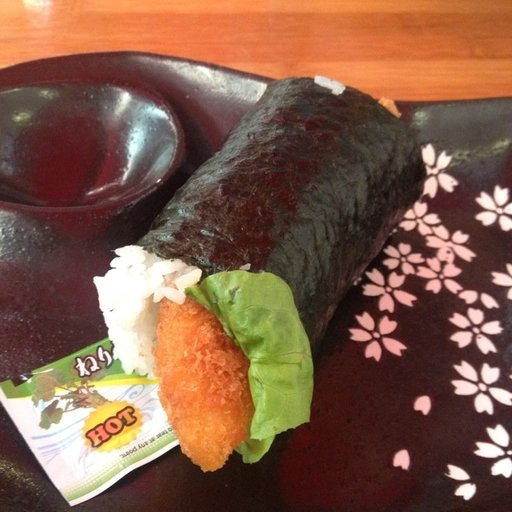

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img=Image.open(random_image_path)
#print
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

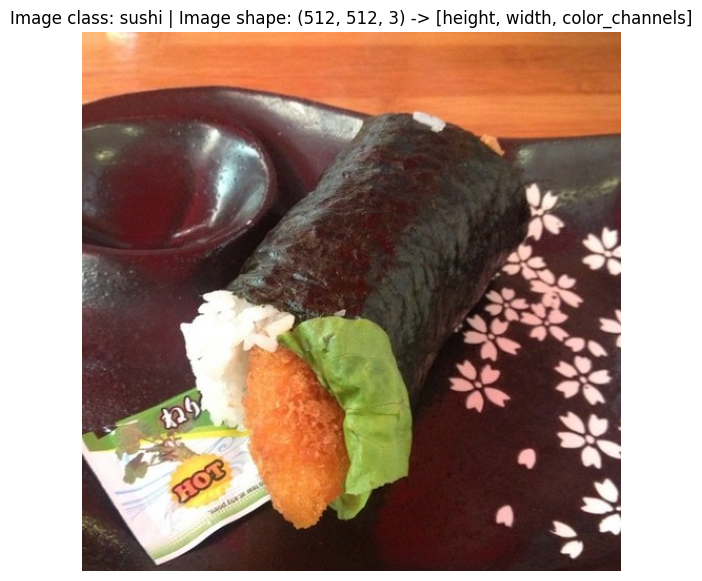

In [ ]:
# the same with matplotlib
import numpy as np
import matplotlib.pyplot as plt
img_as_array=np.asarray(img)
plt.figure( figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## transform

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
#Compile these steps
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

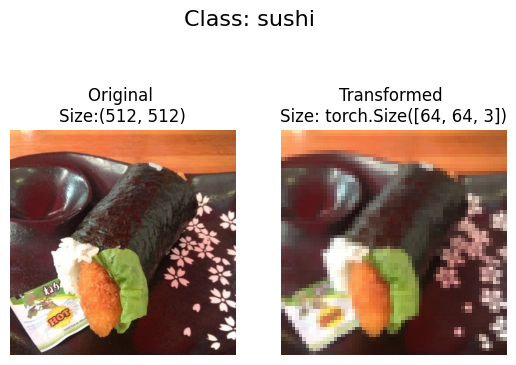

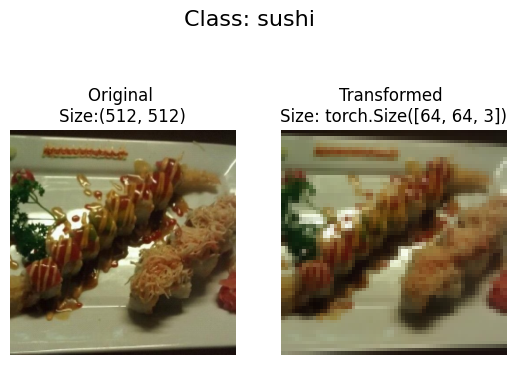

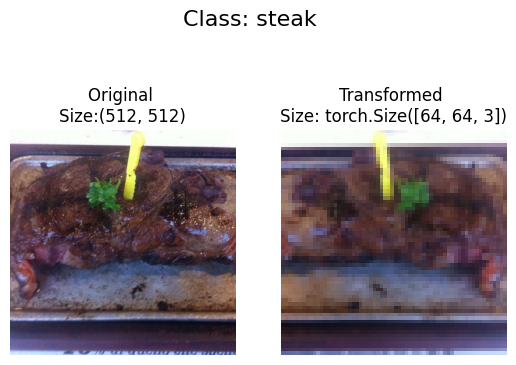

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths , k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax =plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize:{f.size}")
      ax[0].axis("off")

      #transform
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## load image (Option One)

In [ ]:
#Use imageFolder  to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Train data:\n:{train_data}\nTest_data: \n{test_data}")


Train data:
:Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test_data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


##Inspecting Data

In [ ]:

class_names =train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as a dict
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths
len(train_data),len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape:torch.Size([3, 64, 64])
Image permute shape torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

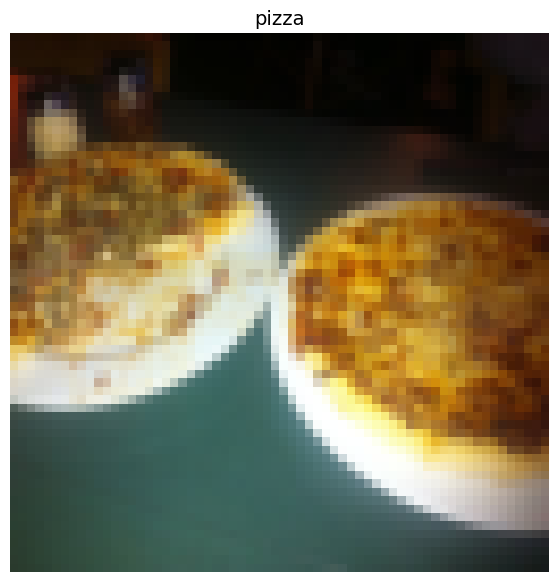

In [ ]:
#Plot Image
img_permute=img.permute(1,2,0)

print(f"Original shape:{img.shape}")
print(f"Image permute shape {img_permute.shape}")

plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label],fontsize=14)

## Turn loaded image imto DataLoader's

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=True)

test_dataloader= DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=1,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c31a636f400>,
 <torch.utils.data.dataloader.DataLoader at 0x7c31a636f310>)

In [ ]:
img,label=next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## Option 2: Loading Image Data with a Custom Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
target_directory = train_dir
print(f"Target directory: {target_directory}")
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [ ]:
# Make a function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
#Test
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# replicate imagefolder
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None)-> None:
    #Class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))#1.解释，不理解
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index:int)->Image.Image:#Image.Image???
    image_path = self.paths[index]
    return Image.open(image_path)#单独演示一下

  def __len__(self)->int:
    return len(self.paths)

  def __getitem__(self, index:int)-> Tuple[torch.Tensor,int]:
    img = self.load_image(index)
    class_name= self.paths[index].parent.name
    class_idx=self.class_to_idx[class_name]

    #Transform if necessary
    if self.transform:
      return self.transform(img),class_idx
    else:
      return img, class_idx

In [ ]:
#解决疑惑：
print("疑惑1：")
targ_dir=train_dir
print(train_dir)
print("-----")
path=list(pathlib.Path(targ_dir).glob("*/*.jpg"))[:10]
path1=path[0]
print(path1)
print(path1.parent)
print(path1.parent.parent)
print(path1.parent.name)
print("\n\n")

疑惑1：
data/pizza_steak_sushi/train
-----
data/pizza_steak_sushi/train/sushi/843815.jpg
data/pizza_steak_sushi/train/sushi
data/pizza_steak_sushi/train
sushi





疑惑2：


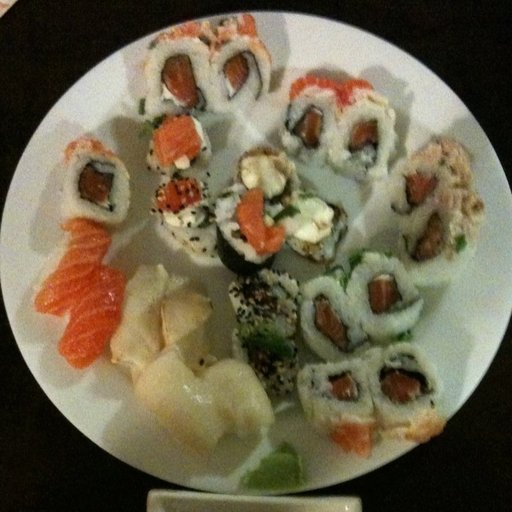

In [ ]:
print("疑惑2：")
Image.open(path1)

In [ ]:
# Compile some transform functions
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c31a638ece0>,
 <__main__.ImageFolderCustom at 0x7c31a638f5e0>)

In [ ]:
# test dataset
print(len(train_data_custom),len(test_data_custom))
print(train_data_custom.classes)
print(train_data_custom.class_to_idx)
print("------------")
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

225 75
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
------------
True
True
True


In [ ]:
# Make a function to randomly display a image
def display_random_images(dataset:torch.utils.data.dataset.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool = True,
                          seed:int = None):
  # 1. n if n is too high
  if n>10:
    n=10
    display_shape = False
    print(f"n is too high, shape display is canceled.")
  # 2.random seed
  random.seed(seed)
  # 3.Get sample indices
  random_samples_idx = random.sample(range(len(dataset)),k=n)
  # 4.plot
  plt.figure(figsize=(16,8))
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # 5.Ajust the image shape for matplotlib
    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
        title = f"class: {classes[targ_label]}"
        if display_shape:
            title = title+f"\nshape:{targ_image_adjust.shape}"
    plt.title(title)


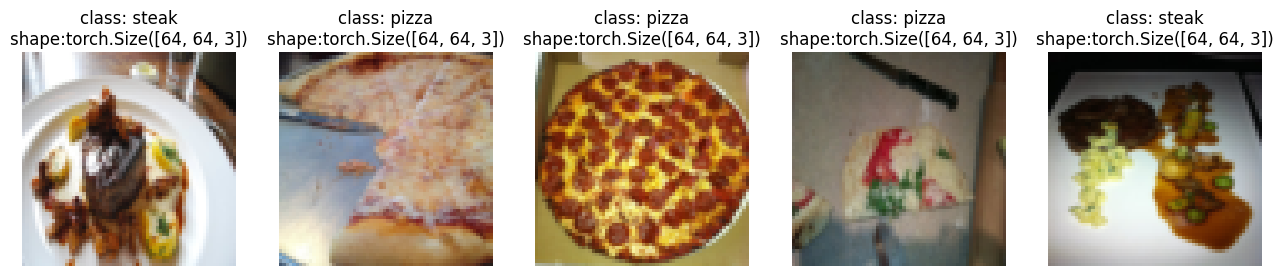

In [ ]:
#Test above function
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

n is too high, shape display is canceled.


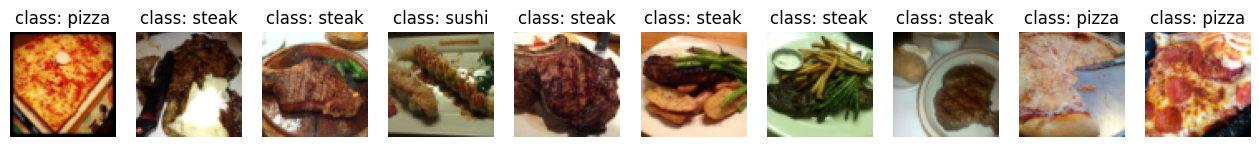

In [ ]:
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

In [ ]:
# Turn custom loaded images into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c31a5ca0e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7c31a6133d00>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## Data Augmentation


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

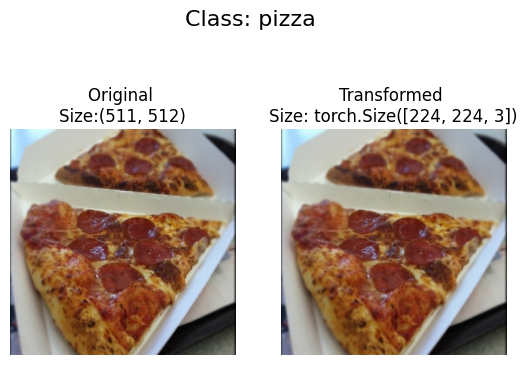

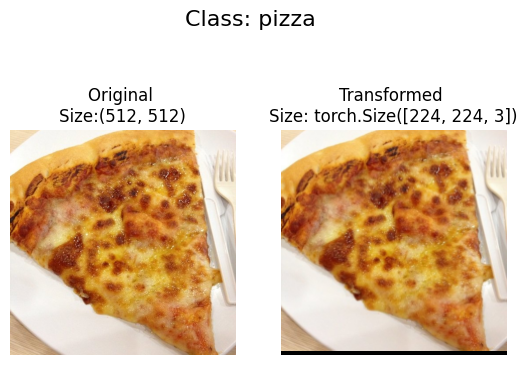

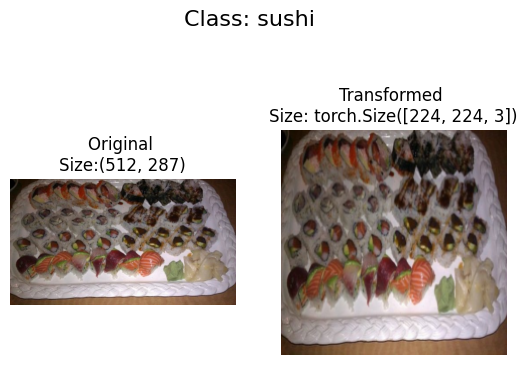

In [ ]:
# Test data augmentation
image_path_list=list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Create TinyVGG model class

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")

train_dataloader_simple=DataLoader(train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle = True,
                                   num_workers = NUM_WORKERS)
test_dataloader_simple=DataLoader(test_data_simple,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
train_dataloader_simple,

Creating DataLoader's with batch size 32 and 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x7c31a643be50>,)

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape:int)->None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3,padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  def forward(self,x:torch.Tensor):
    assert x.ndim == 4, "Input must be a 4D tensor"
    x=self.conv_block_1(x)
    x=self.conv_block_2(x)
    x=self.classifier(x)
    return x
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                    hidden_units=10,
                    output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## Test the model

In [ ]:
# Get a batch
img_batch, label_batch = next(iter(train_dataloader_simple))
# Get a image
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# Perform forward pass
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")


Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [ ]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Create train and test loop functions

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Set up
    model.train()
    train_loss, train_acc= 0,0

    # Loop through data
    for batch ,(X,y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = model(X)

      # Calculate the loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()#为什么item()?

      # backward
      loss.backward()

      # optimizer step
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    # Average metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Set up
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
# def train() to combine above two
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
              "train_acc":[],
              "test_loss":[],
              "test_acc": []
              }
    # loop through
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                              dataloader=train_dataloader,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        #update
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [ ]:
# set up
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1030 | train_acc: 0.2344 | test_loss: 1.1790 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0784 | train_acc: 0.4258 | test_loss: 1.2525 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1545 | train_acc: 0.2930 | test_loss: 1.1860 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1132 | train_acc: 0.4141 | test_loss: 1.0945 | test_acc: 0.4195
Epoch: 5 | train_loss: 1.0977 | train_acc: 0.2969 | test_loss: 1.1052 | test_acc: 0.1979
Total training time: 13.830 seconds


## Plot Loss Curve

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy= results['test_acc']

  epochs=range(len(results['train_loss']))

  plt.figure(figsize=(15,7))
  # Plot loss
  plt.subplot(1 ,2 ,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


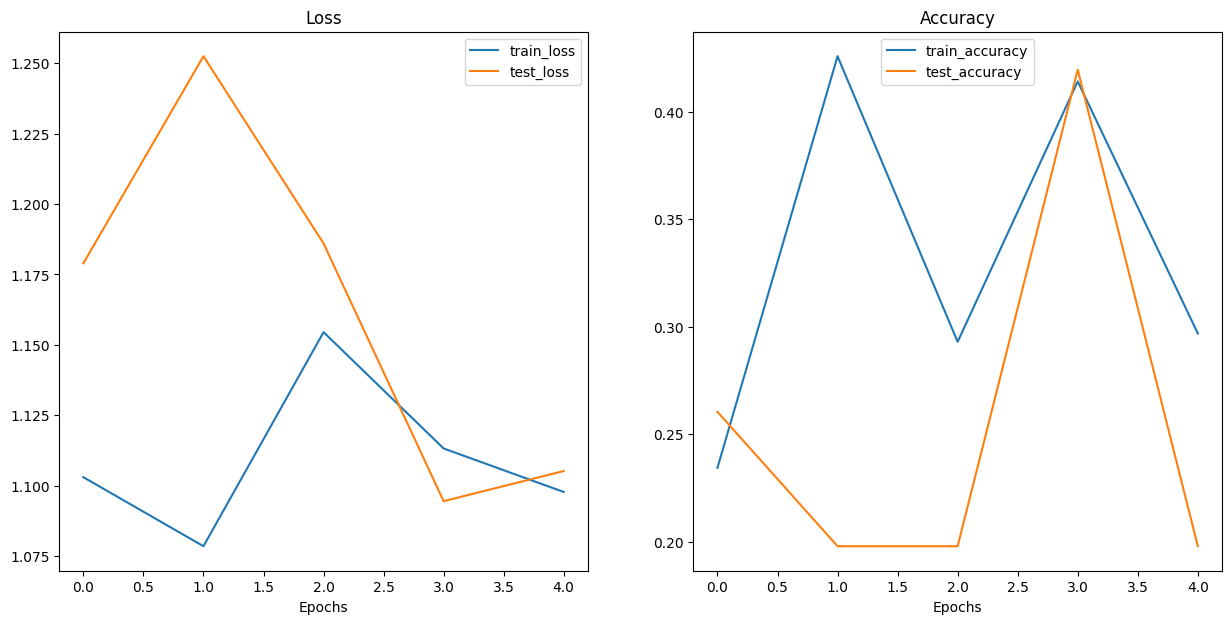

In [ ]:
plot_loss_curves(model_0_results)

# Data Augmentation

In [ ]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Turn  Image folder into datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c31a633eaa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c31a636f310>)

In [ ]:
# Create model_1
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set up
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# Print
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1191 | train_acc: 0.2500 | test_loss: 1.1131 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.0705 | train_acc: 0.4375 | test_loss: 1.1766 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0812 | train_acc: 0.4258 | test_loss: 1.2514 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1743 | train_acc: 0.3047 | test_loss: 1.1996 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1043 | train_acc: 0.4258 | test_loss: 1.1094 | test_acc: 0.2604
Total training time: 15.442 seconds


# Evaluation

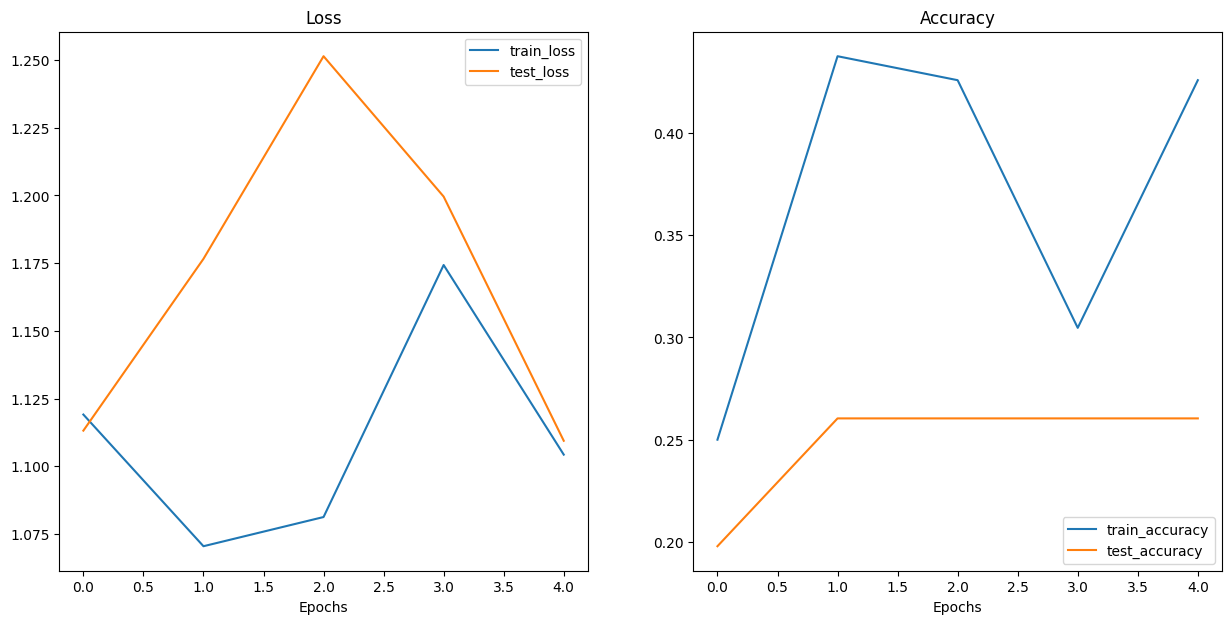

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.102969   0.234375   1.178955  0.260417
1    1.078449   0.425781   1.252520  0.197917
2    1.154495   0.292969   1.186011  0.197917
3    1.113177   0.414062   1.094457  0.419508
4    1.097721   0.296875   1.105169  0.197917

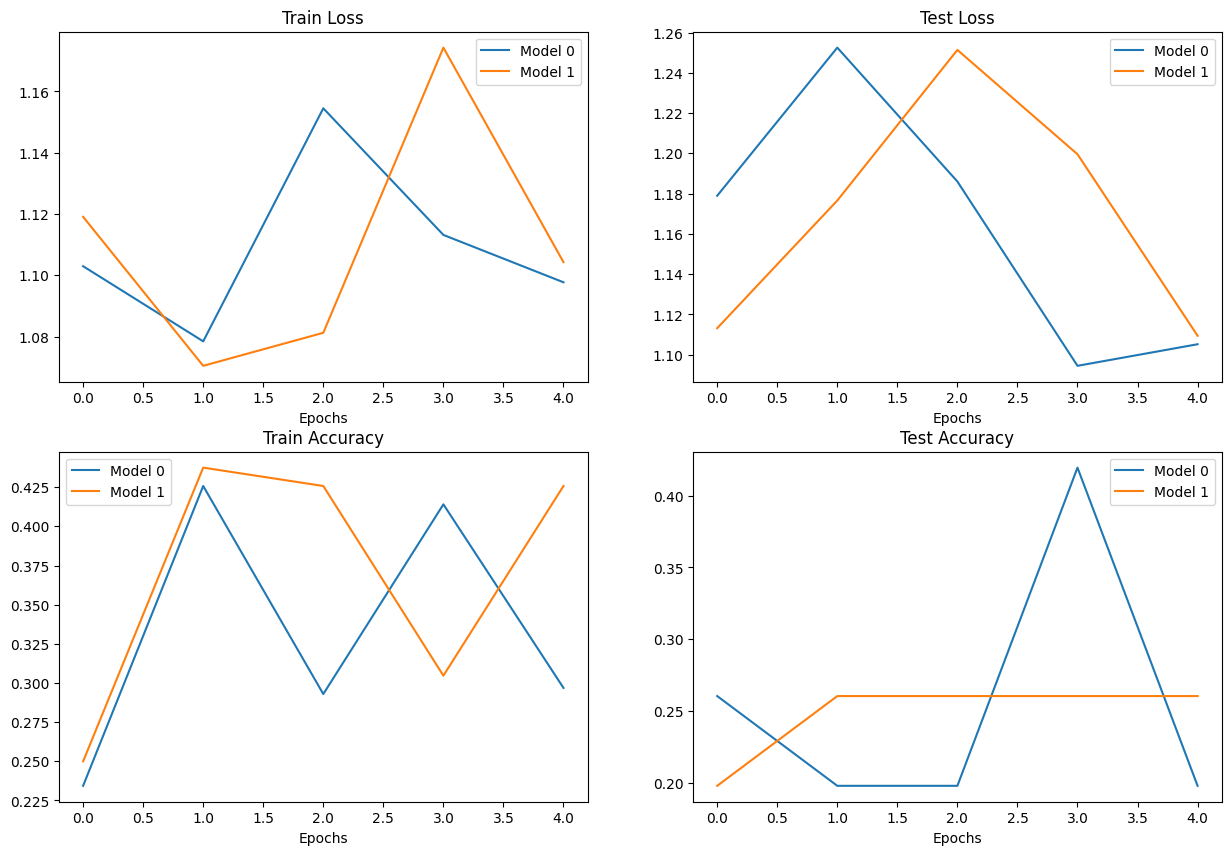

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Make a prediction on a custom image


In [ ]:
# Download custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists.")

### Preproccess image

In [ ]:
# load image
import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255.

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

(-0.5, 3023.5, 4031.5, -0.5)

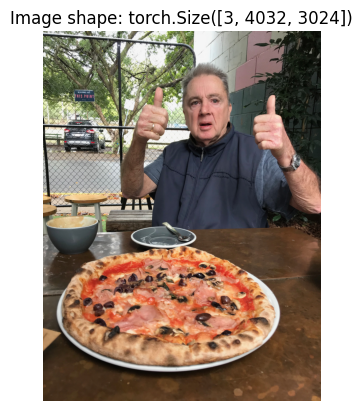

In [ ]:
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [ ]:
# Transform image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

custom_image_transformed = custom_image_transform(custom_image)

# Print
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [ ]:
custom_image_pred

tensor([[ 0.0448, -0.0128, -0.0425]])

In [ ]:
# Convert logits to label
print(f"logits: {custom_image_pred}")
custom_image_probs=torch.softmax(custom_image_pred,dim=1)
print(f"Probability: {custom_image_probs}")
label=torch.argmax(custom_image_probs,dim=1)
print(f"Predicted label: {label}")
print(class_names[label])

logits: tensor([[ 0.0448, -0.0128, -0.0425]])
Probability: tensor([[0.3496, 0.3300, 0.3204]])
Predicted label: tensor([0])
pizza


## Put it all together

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names: List[str]=None,
                        transform=None,
                        device:torch.device=device):

  # 1.change the type
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2.standardize the pixel value
  target_image = target_image /255

  # 3.transform image
  if transform:
    target_image = transform(target_image)

  # 4.put it to device
  model.to(device)

  # 5.evaluate
  model.eval()
  with torch.inference_mode():
    target_image_pred=model(target_image.to(device).unsqueeze(dim=0))

  # 6.change logits to label
  probs = torch.softmax(target_image_pred, dim=1)
  label = torch.argmax(probs, dim=1)

  # 7.plot
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
      title = f"Pred: {class_names[label.cpu()]} | Prob: {probs.max().cpu():.3f}"
  else:
      title = f"Pred: {label} | Prob: {probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


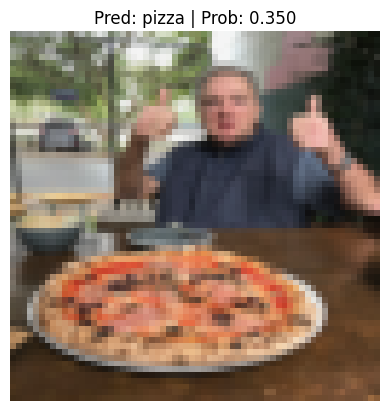

In [ ]:
# Testing
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

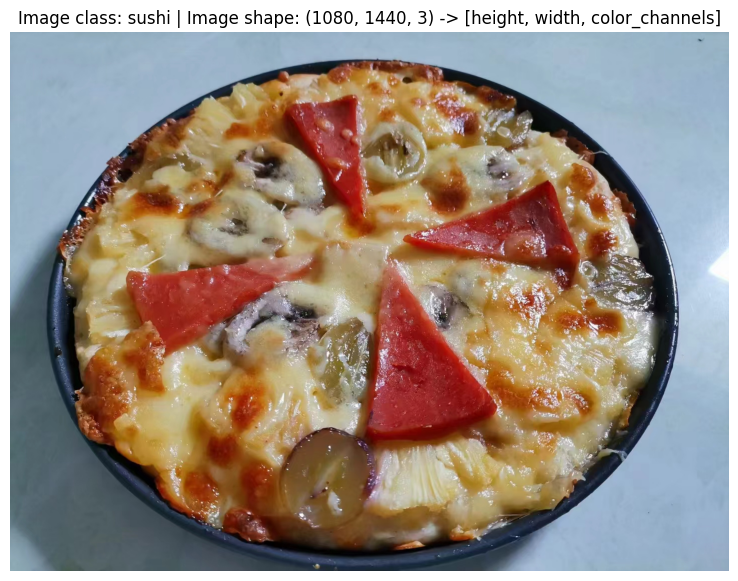

In [ ]:
img=Image.open("/content/微信图片_20240424212048.jpg")
import numpy as np
import matplotlib.pyplot as plt
img_as_array=np.asarray(img)
plt.figure( figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


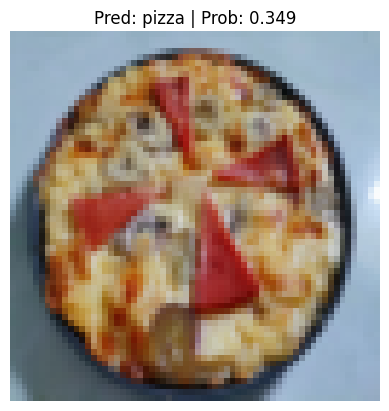

In [ ]:
# Testing
pred_and_plot_image(model=model_1,
                    image_path="/content/微信图片_20240424212048.jpg",
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)